<h3>Contenidos:<h3/>

* [Imporatcion librerías y df](#librerias-df)
* [Visualización](#visualizacion)
  * [Primeras estadisticas](#visualizacion-primeras)
  * [Histogramas](#visualizacion-hist)
  * [Graficos de Barras](#visualizacion-barras)
* [Feature Engineering & Feature Selection](#fe&fs)
  * [Discretizacion](#fe&fs-disc)
  * [Tratamiento variables categoricas](#fe&fs-catvars)
    * [Tratamiento de nans](#fe&fs-catvars-nans)
    * [Encoding](#fe&fs-catvars-encoding)
    * [Encoding Performance](#fe&fs-catvars-encoding-performance)
  * [Feature Selection](#fe&fs-fs)
    * [Features constantes](#fe&fs-fs-fc)
    * [Features correlacionados](#fe&fs-fs-fcorr)
    * [Chi-cuadrado](#fe&fs-fs-chi)
    * [Mutual Information](#fe&fs-fs-mi)
    * [Feature Importance](#fe&fs-fs-importance)
* [Model performance](#model-performance)

<a name="librerias-df"></a>
# Importación de librerías y dataframe.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from scipy.stats import chi2_contingency

In [2]:
# cargo desde el disco el dataframe
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


In [3]:
# creo el obj dataframe con pandas
df = pd.read_csv("bank-additional-full.csv", delimiter=';')

# muestro las primas filas del df
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Separo los datos en train & test set para empezar con el análisis.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    df["y"],
                                                    train_size = 0.7,
                                                    random_state= 0)
X_train.shape, X_test.shape

((28831, 21), (12357, 21))

**OBS:** podemos ver que hay un label llamado `unknown`, dicho label es un indicador de datos faltantes. Voy a reemplazar en todos los features los labels `unknown` por nans y luego trataré las variables nulas.

In [41]:
X_train["job"].unique()

array(['management', 'blue-collar', 'services', 'entrepreneur', 'admin.',
       'technician', 'retired', 'unemployed', 'self-employed',
       'housemaid', 'student', 'unknown'], dtype=object)

In [42]:
X_train["education"].unique()

array(['university.degree', 'basic.9y', 'professional.course',
       'high.school', 'basic.4y', 'basic.6y', 'unknown', 'illiterate'],
      dtype=object)

In [43]:
X_train.replace("unknown", np.nan, inplace=True)
X_test.replace("unknown", np.nan, inplace=True)

**OBS:** Solo tenemos nans en algunas variables categóricas.

In [44]:
X_train.isnull().sum()

age                  0
job                227
marital             57
education         1203
default           5985
housing            689
loan               689
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

<a name="visualizacion"></a>
# Visualización del dataframe.

<a name="visualizacion-hist"></a>
## Histogramas.

In [45]:
# divido el df segun el target para comparar histogramas
sub_clients = X_train[X_train["y"] == "yes"]
no_sub_clients = X_train[X_train["y"] == "no"]

Podemos notar que hay muchas diferencias en los histogramas de los sig features:

* `euribor3m`.
* `cons.conf.idx`.
* `cons.price.idx`.
* `campaign`. 
* `duration`.


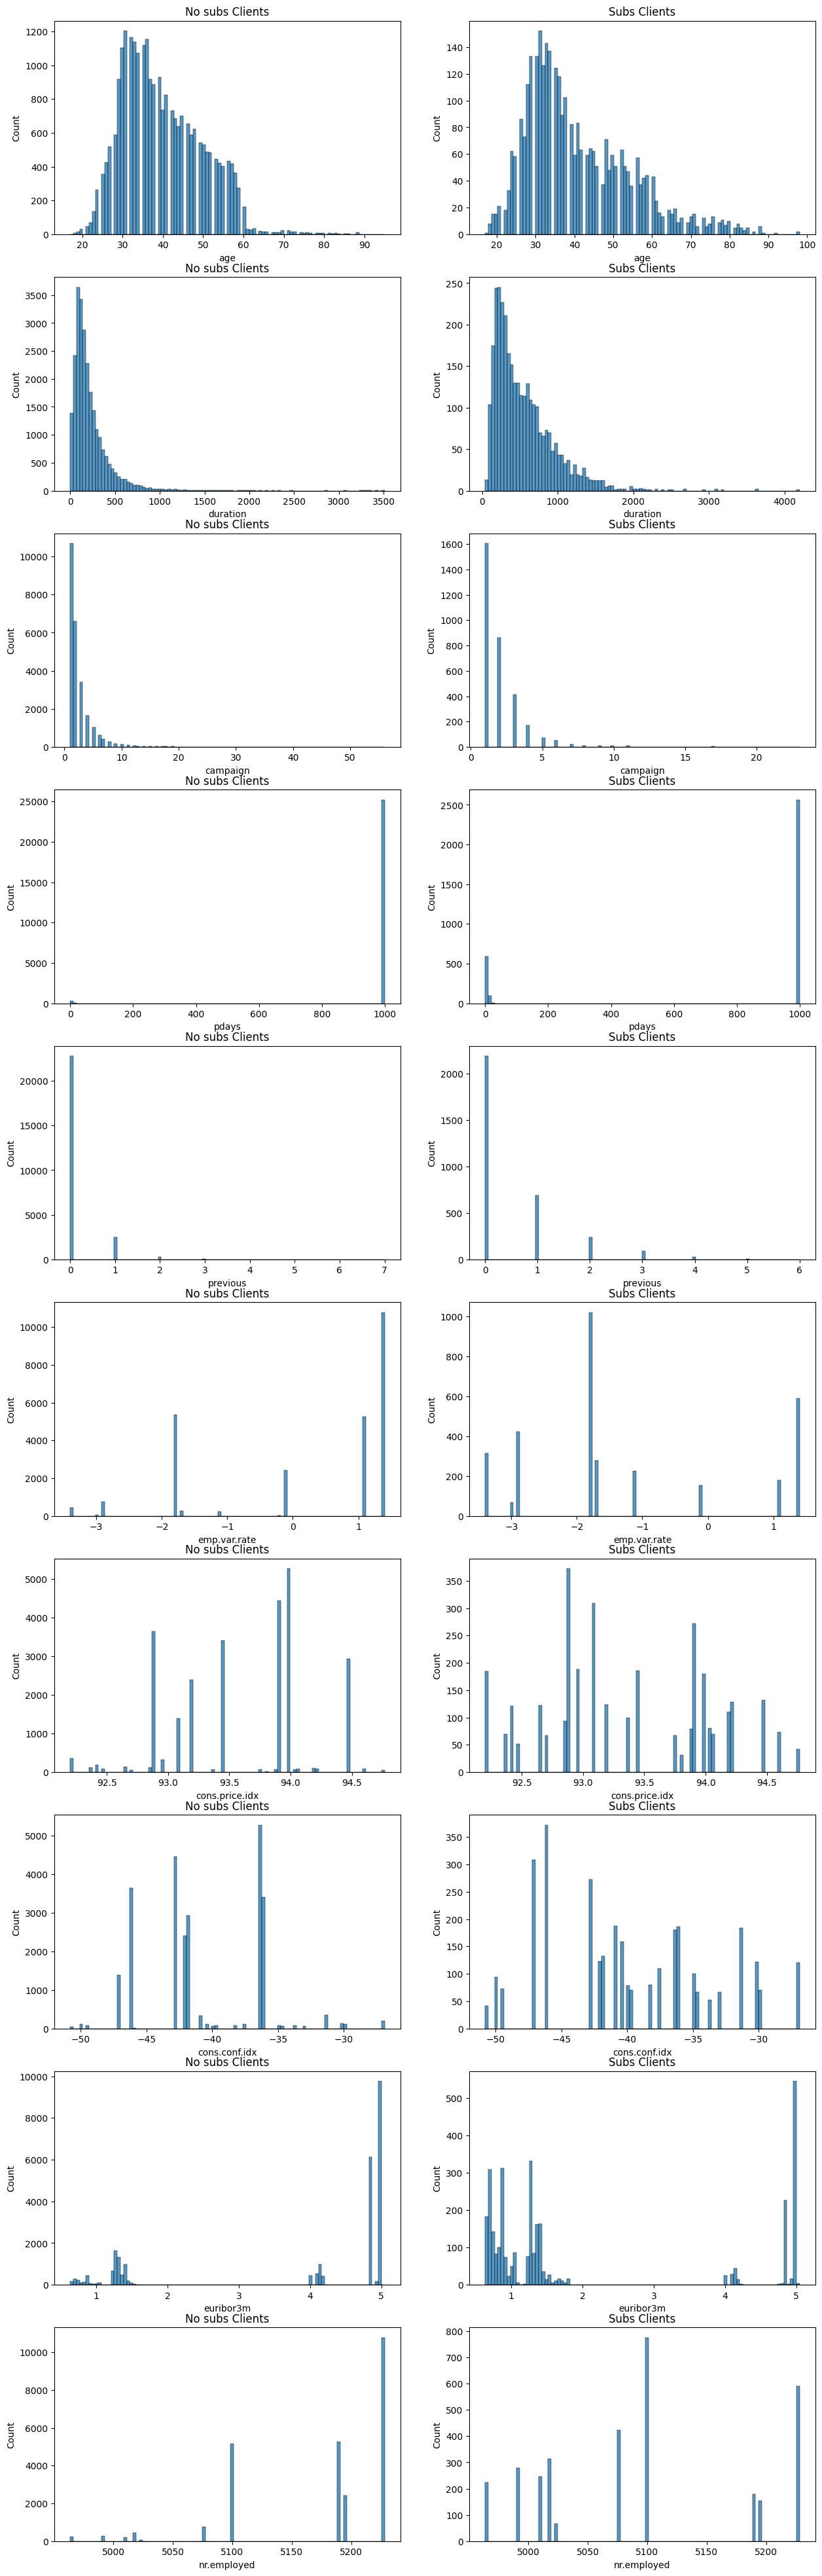

In [46]:
# obtengo features numericos
num_feats = [feat for feat in X_train.columns if X_train[feat].dtype != np.object_]

f, axs = plt.subplots(10, 2, figsize=(15,50))

# ploteo los histogramas en los features numericos haciendo una comparativa
# entre los clientes suscriptos vs no-suscriptos
for i in range(10):
  for j in range(2):
    if j==0:
      sns.histplot(no_sub_clients[num_feats[i]], ax=axs[i, j], bins=100).set(title="No subs Clients")
    else:
      sns.histplot(sub_clients[num_feats[i]], ax=axs[i, j], bins=100).set(title="Subs Clients")

<a name="visualizacion-barras"></a>
## Graficos de Barras

Podemos ver que tenemos un 88% observaciones de clientes que NO se suscriben al depósito.

In [47]:
X_train["y"].value_counts(normalize=True)

no     0.887205
yes    0.112795
Name: y, dtype: float64

Podemos ver el promedio de los features y vemos que hay algunos que cambian segun el valor que opta el target.
Como por ejm:

 * pdays.
 * emp.var.rate.
 * euribor3m.
 * previous.

In [48]:
X_train.groupby(by="y").mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.853434,221.300168,2.62868,984.558818,0.129872,0.250616,93.605412,-40.583830,3.814656,5176.196051
yes,40.931734,547.435117,2.04182,788.616236,0.496925,-1.243573,93.355895,-39.826353,2.110593,5094.369772


**ALGUNAS OBS:** 
Pareciera haber cierta relación entre el target y los sig features categóricos:

* `job` esto podría ser debido a que el servicio ofrecido podría favorecer más a los clientes que tengan cierto tipo de trabajo.
* `month` podemos ver que hay meses en donde la cantidad de clientes suscriptos son iguales a los que decidieron no suscribirse al depósito.
* `poutcome` podemos ver que los resultados de campañas de marketing anteriores tienen mucha influencia.


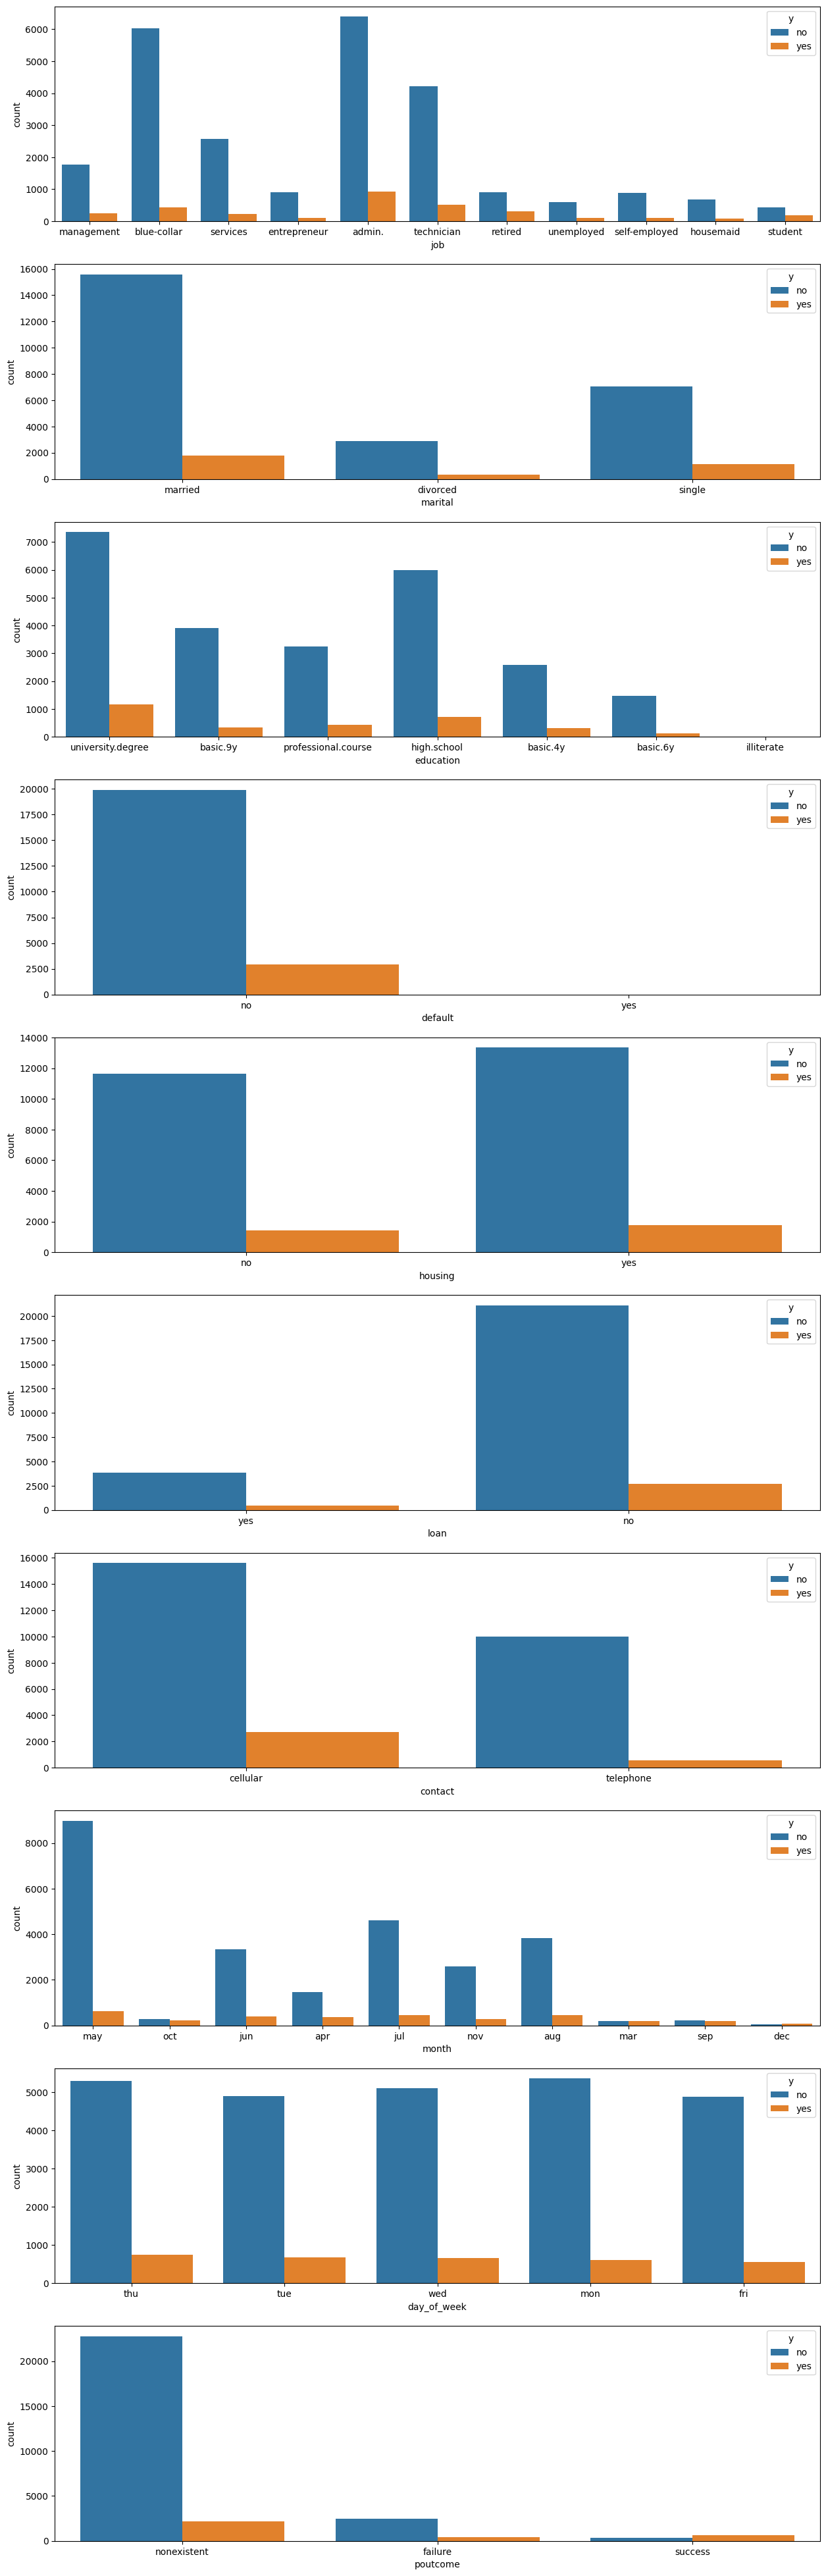

In [49]:
# obtengo features categoricos
cat_feats = [feat for feat in X_train.columns if X_train[feat].dtype == np.object_]

f, axs = plt.subplots(len(cat_feats) -1 , 1, figsize=(15,50))

for i in range(len(cat_feats)-1):
  sns.countplot(x=cat_feats[i], hue = "y", data = X_train, ax=axs[i])

Agrupo por trabajo y por target para analizar los contactos previos que se hicieron a los clientes con determinados trabajos.

In [50]:
X_train.groupby(["job","y"])["previous"].mean().unstack(1)

y,no,yes
job,,
admin.,0.142165,0.519397
blue-collar,0.105220,0.283105
entrepreneur,0.122404,0.291667
housemaid,0.076233,0.555556
management,0.139140,0.560000
retired,0.203765,0.614618
self-employed,0.124717,0.297030
services,0.133229,0.351111
student,0.361949,0.804233


Creo una nueva columna que indicara el trimestre al cual pertenece dicho mes en la observación, esto lo hago para poder analizar los atributos de los contextos económicos y sociales.

In [51]:
# creo los trimestres
Q1 = ["mar"]
Q2 = ["apr", "may", "jun"]
Q3 = ["jul", "aug", "sep"]
Q4 = ["oct", "nov", "dec"]

# funcion que codifica cada mes en su determinado trimestre
def month_encode(month):
  if (month in Q1):
    return "Q1"
  elif (month in Q2):
    return "Q2"
  elif (month in Q3):
    return "Q3"
  else:
    return "Q4"

# creo la nueva columna
X_train["month_quarterly"] = X_train["month"].map(lambda x: month_encode(x))
X_test["month_quarterly"] = X_test["month"].map(lambda x: month_encode(x))

In [52]:
# agrupo por trimestre y calculo la media
X_train.groupby("month_quarterly")[["emp.var.rate", "cons.price.idx", "cons.conf.idx", 
                                    "euribor3m", "nr.employed"]].mean()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
month_quarterly,,,,,
Q1,-1.800000,93.082468,-43.080000,1.189966,5057.944211
Q2,-0.149383,93.656674,-41.486864,3.302681,5154.638503
Q3,0.834989,93.614511,-39.035163,4.352027,5198.445024
Q4,-0.806449,93.185247,-40.020739,3.238495,5144.512358


Podemos ver que cada trimestre presenta un valor bastante diferente en lo que refiere al feature `euribor3m`.

Este feature es un índice de referencia publicado diariamente que **indica el tipo de interés promedio** .

Dicho esto, tiene sentido pensar que si dicho interés es bajo, los clientes estarán más interesados en suscribirse al depósito.

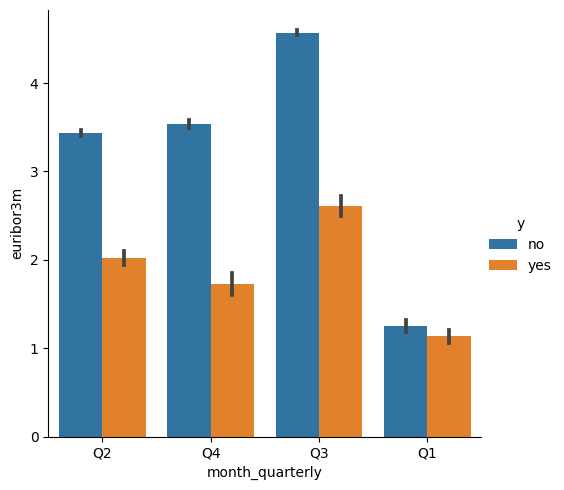

In [53]:
sns.catplot(data=X_train, x="month_quarterly", 
            y="euribor3m", kind="bar", hue="y")

Siendo un poco redundante podemos ver respecto a los meses.

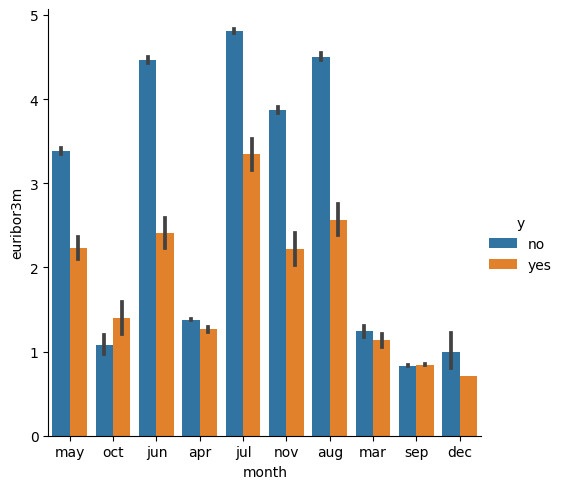

In [54]:
sns.catplot(data=X_train, x="month", 
            y="euribor3m", kind="bar", hue="y")

Podemos ver el promedio de campañas por mes.

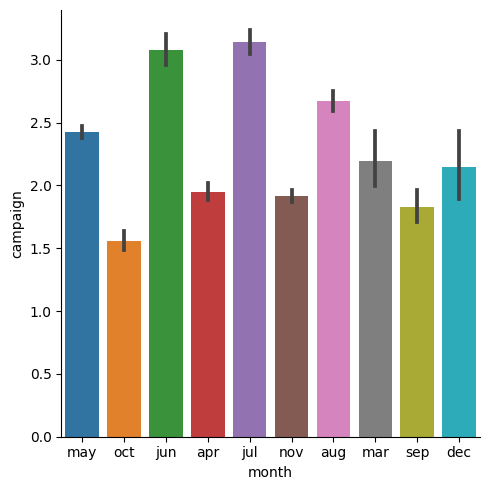

In [55]:
sns.catplot(data=X_train, x="month", y="campaign", kind="bar")

<a name="fe&fs"></a>
# Feature Engineering & Feature Selection.

<a name="fe&fs-disc"></a>
## Discretizacion de variables.

La discretización es el proceso de transformar variables continuas en variables discretas mediante la creación de un conjunto de intervalos contiguos que abarcan el rango de valores de la variable.

**OBS:**

La discretización ayuda a manejar outliars y puede mejorar la distribución en variables con distribuciones tipo long tail.

### Discretizar feature `campaign`.


In [56]:
# creo el nombre de los intervalos
labels = ['Q'+str(i) for i in range(1,5)]
labels

['Q1', 'Q2', 'Q3', 'Q4']

In [57]:
X_train["campaign_bin"], intervals = pd.qcut(X_train['campaign'], 10, labels=labels,
                                      retbins=True,
                                      precision=3, duplicates='drop')

# extiendo los limites para que no haya obs que caigan fuera de los limites
intervals[0] = float("-inf")
intervals[len(intervals) - 1] = float("inf")

X_train["campaign_interval"] = pd.cut(x = X_train['campaign'], bins=intervals)

X_train[["campaign_bin", "campaign_interval"]].head()

,campaign_bin,campaign_interval
31880,Q1,"(-inf, 2.0]"
38177,Q1,"(-inf, 2.0]"
2459,Q1,"(-inf, 2.0]"
756,Q2,"(2.0, 3.0]"
11275,Q1,"(-inf, 2.0]"


In [58]:
# for check
display(X_train["campaign_bin"].value_counts(),
        X_train["campaign_interval"].value_counts())

Q1    19757
Q2     3801
Q3     2946
Q4     2327
Name: campaign_bin, dtype: int64

(-inf, 2.0]    19757
(2.0, 3.0]      3801
(3.0, 5.0]      2946
(5.0, inf]      2327
Name: campaign_interval, dtype: int64

In [59]:
# aplico la discretizacion en el test-set
X_test['campaign_bin'] = pd.cut(x = X_test['campaign'], bins=intervals, labels=labels)
X_test['campaign_interval'] = pd.cut(x = X_test['campaign'], bins=intervals)

X_test[["campaign", "campaign_bin", "campaign_interval"]].head()

,campaign,campaign_bin,campaign_interval
15500,3,Q2,"(2.0, 3.0]"
29034,2,Q1,"(-inf, 2.0]"
11199,1,Q1,"(-inf, 2.0]"
22247,7,Q4,"(5.0, inf]"
27180,1,Q1,"(-inf, 2.0]"


In [60]:
# checkeo nans
X_test[['campaign_bin', "campaign_interval"]].isnull().sum()

campaign_bin         0
campaign_interval    0
dtype: int64

In [61]:
# checkeo nans
X_train[['campaign_bin', "campaign_interval"]].isnull().sum()

campaign_bin         0
campaign_interval    0
dtype: int64

**OBS:** si las distribuciones en el conjunto de entrenamiento y el conjunto de prueba son similares $\Rightarrow$ deberíamos esperar una proporción similar de observaciones en los diferentes intervalos.

Text(0, 0.5, 'Number of observations per bin')

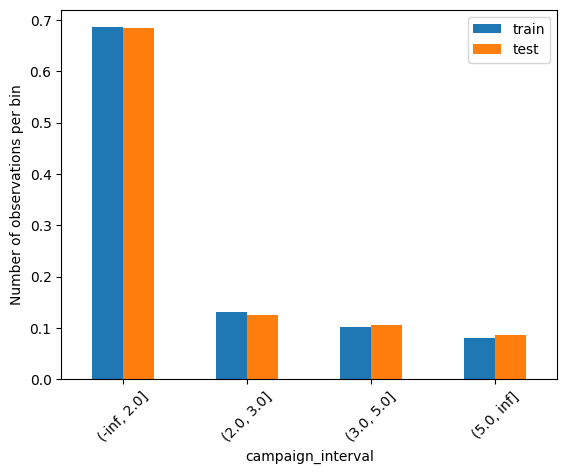

In [62]:
train = X_train.groupby(['campaign_interval'])['campaign'].count() / len(X_train)
test = X_test.groupby(['campaign_interval'])['campaign'].count() / len(X_test)

tmp = pd.concat([train, test], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

In [63]:
# casteo los columnas nuevas a str
X_train[["campaign_bin"]]= X_train[["campaign_bin"]].astype(str)
X_test[["campaign_bin"]]= X_test[["campaign_bin"]].astype(str)

In [64]:
# borro las columnas campaign_interval puesto que se crearon solo para visualizar los intervalos
X_train.drop(["campaign_interval"],axis=1, inplace=True)
X_test.drop(["campaign_interval"],axis=1, inplace=True)

In [65]:
# capturo el rango de age
age_range = X_train['age'].max() - X_train['age'].min()

# obtengo los limites
min_value = int(np.floor( X_train['age'].min()))
max_value = int(np.ceil( X_train['age'].max()))

# redondeo el ancho del intervalo
inter_value = int(np.round(age_range / 8))

min_value, max_value, inter_value

(17, 98, 10)

In [66]:
# obtengo los limites para cada sub-intervalo
intervals_limits = [i for i in range(min_value, max_value+inter_value, inter_value)]

intervals_limits

[17, 27, 37, 47, 57, 67, 77, 87, 97, 107]

In [67]:
# obtengo los bins
bins = ['Bin_' + str(i) for i in range(1, len(intervals_limits))]
bins

['Bin_1',
 'Bin_2',
 'Bin_3',
 'Bin_4',
 'Bin_5',
 'Bin_6',
 'Bin_7',
 'Bin_8',
 'Bin_9']

In [68]:
X_train["age_bin"] = pd.cut(x=X_train["age"],
                                    bins=intervals_limits,
                                    labels=bins,
                                    include_lowest=True)


X_train["age_interval"] = pd.cut(x=X_train["age"],
                             bins=intervals_limits,
                             include_lowest=True)

X_train[["age", "age_bin", "age_interval"]].head()

,age,age_bin,age_interval
31880,37,Bin_2,"(27.0, 37.0]"
38177,54,Bin_4,"(47.0, 57.0]"
2459,49,Bin_4,"(47.0, 57.0]"
756,30,Bin_2,"(27.0, 37.0]"
11275,23,Bin_1,"(16.999, 27.0]"


In [69]:
# aplico la discretizacion en el test-set
X_test['age_bin'] = pd.cut(x=X_test['age'],
                                   bins=intervals_limits,
                                   labels=bins,
                                   include_lowest=True)

X_test['age_interval'] = pd.cut(x=X_test['age'],
                            bins=intervals_limits,
                            include_lowest=True)

X_test[['age_bin','age_interval']].head()

,age_bin,age_interval
15500,Bin_3,"(37.0, 47.0]"
29034,Bin_4,"(47.0, 57.0]"
11199,Bin_3,"(37.0, 47.0]"
22247,Bin_4,"(47.0, 57.0]"
27180,Bin_4,"(47.0, 57.0]"


In [70]:
# checkeo nans
X_train["age_bin"].isnull().sum()

0

In [71]:
# checkeo nans
X_test["age_bin"].isnull().sum()

0

Text(0, 0.5, 'Number of observations per bin')

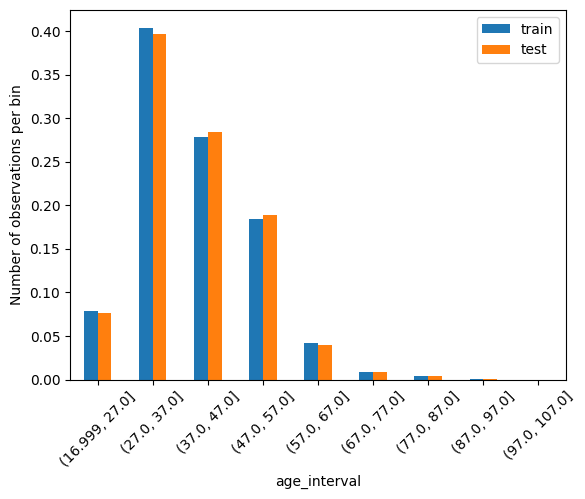

In [72]:
train = X_train.groupby(['age_interval'])['age'].count() / len(X_train)
test = X_test.groupby(['age_interval'])['age'].count() / len(X_test)

tmp = pd.concat([train, test], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

In [73]:
# casteo las columnas nuevas a str
X_train[["age_bin"]]= X_train[["age_bin"]].astype(str)
X_test[["age_bin"]]= X_test[["age_bin"]].astype(str)

In [74]:
# borro las columnas age_interval puesto que se crearon solo para visualizar los intervalos
X_train.drop(["age_interval"],axis=1, inplace=True)
X_test.drop(["age_interval"],axis=1, inplace=True)

<a name="fe&fs-catvars"></a>
## Tratamiento de variables categóricas.

<a name="fe&fs-catvars-nans"></a>
### Tratamiento valores nulos.

In [75]:
# obtengo los features con nans
features_w_nans = [feat for feat in X_train.columns if X_train[feat].isnull().any()]
features_w_nans

['job', 'marital', 'education', 'default', 'housing', 'loan']

In [76]:
X_tmp = X_train.copy()

# codificamos el target para hacer algunos calculos al respecto los valores nulos
X_tmp["y"] = np.where(X_train["y"]=="yes", 1, 0)

Podemos ver que tenemos muy pocos valores nulos.
Salvo en el feature **default** que hay un 20% de valores nulos.


In [85]:
for feature in features_w_nans:
  print("=========================================================")
  print("Valor del target segun los nulos")
  print(f"Feature: {feature}")
  display(X_tmp[X_tmp[feature].isnull()]["y"].value_counts())
  print(f"\nEl porcentaje de nulos es de: {X_tmp[feature].isnull().mean()}\n")
  print("=========================================================")

Valor del target segun los nulos
Feature: job


0    204
1     23
Name: y, dtype: int64


El porcentaje de nulos es de: 0.007873469529326072

Valor del target segun los nulos
Feature: marital


0    48
1     9
Name: y, dtype: int64


El porcentaje de nulos es de: 0.001977038604280115

Valor del target segun los nulos
Feature: education


0    1027
1     176
Name: y, dtype: int64


El porcentaje de nulos es de: 0.041725920016648745

Valor del target segun los nulos
Feature: default


0    5670
1     315
Name: y, dtype: int64


El porcentaje de nulos es de: 0.2075890534494121

Valor del target segun los nulos
Feature: housing


0    619
1     70
Name: y, dtype: int64


El porcentaje de nulos es de: 0.02389788769033332

Valor del target segun los nulos
Feature: loan


0    619
1     70
Name: y, dtype: int64


El porcentaje de nulos es de: 0.02389788769033332



**Para tratar los valores nulos elegiremos dos metodos y comparemos resultados.**

* Drop ie eliminaremos las filas que contengan nulos.
 
* Frequent category imputation ie reemplazaré los valores nulos por los valores más frecuentes en dichos features.

Drop method:

In [86]:
X_train_drop = X_train.copy()
X_test_drop = X_test.copy()

# dropeamos las filas
X_train_drop = X_train.dropna()
X_test_drop = X_test.dropna()

Frequent category imputation method:

In [87]:
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

for feature in features_w_nans:
  # calculo las cantidades de obs de cada label para cada feature
  count_labels = X_train[feature].value_counts(ascending=False)

  # obtengo el label mas frecuente
  most_freq_label = count_labels.index[0]

  # reemplazo los nans por el label mas frecuente
  X_train_imputed[feature] = X_train[feature].fillna(most_freq_label)
  X_test_imputed[feature] = X_test[feature].fillna(most_freq_label)

In [88]:
X_train_imputed[features_w_nans].isnull().sum()

job          0
marital      0
education    0
default      0
housing      0
loan         0
dtype: int64

In [89]:
X_train_drop[features_w_nans].isnull().sum()

job          0
marital      0
education    0
default      0
housing      0
loan         0
dtype: int64

#### Análisis.

Podemos ver que no hay mucha diferencia en la distribución de los datos entre el antes y el después de la imputacion pero si con el metodo de dropeo, por lo tanto optaremos por utilizar el metodo de imputacion.

In [94]:
X_tmp["job"].isnull().mean()

0.007873469529326072

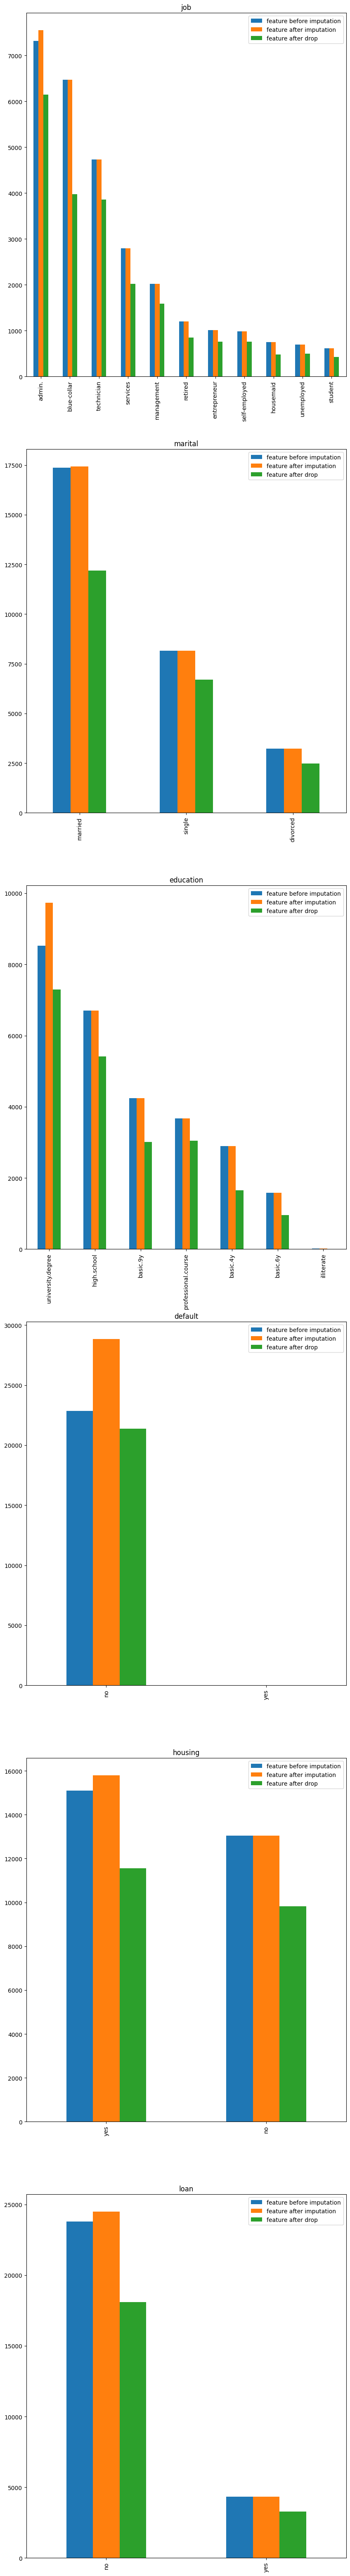

In [90]:
f, axs = plt.subplots(len(features_w_nans), 1, figsize=(10,80))

for i in range(len(features_w_nans)):
  df_tmp = pd.concat([X_train[features_w_nans[i]].value_counts(ascending=False).rename('feature before imputation'), 
                      X_train_imputed[features_w_nans[i]].value_counts(ascending=False).rename('feature after imputation'),
                      X_train_drop[features_w_nans[i]].value_counts(ascending=False).rename('feature after drop')], axis=1)
  
  df_tmp.plot.bar(ax=axs[i], title=features_w_nans[i])

In [98]:
X_train = X_train_imputed
X_test = X_test_imputed

<a name="fe&fs-catvars"></a>
### Categorical encoding.

Codificaré las variables categóricas con distintos aprouchs para luego evaluar la performance de c/u y saber que aprouch es el más óptimo.

#### Funciones para el encoding de variables categoricas.

In [99]:
# crea variables binarias por cada label en dicho feature
# indicando con un 1 el valor de cada label en su debida columna
def one_hot_encoding(X_train, X_test, features):
  X_train_r = X_train.copy()
  X_test_r = X_test.copy()

  for feat in features:
    # declaro la clase ohe
    encoder = OneHotEncoder(categories='auto',
                        drop='first',
                        sparse=False,
                        handle_unknown='error')
    
    encoder.fit(X_train[[feat]])

    # obtengo los valores codificados
    ohe_feature_train = encoder.transform(X_train[[feat]])
    ohe_feature_test = encoder.transform(X_test[[feat]])

    # obtengo el nombre de las nuevas columnas
    new_columns_names = encoder.get_feature_names_out()

    # creo el dataframe con las nuevas columnas y dichos valores codificados
    ohe_feature_train = pd.DataFrame(ohe_feature_train,columns=new_columns_names)
    ohe_feature_test = pd.DataFrame(ohe_feature_test,columns=new_columns_names)

    X_train_r= pd.concat([ohe_feature_train.reset_index(drop=True), X_train_r.reset_index(drop=True)], axis=1)
    X_test_r = pd.concat([ohe_feature_test.reset_index(drop=True), X_test_r.reset_index(drop=True)], axis=1)

  return X_train_r, X_test_r

# agrupa por feature y calcula la media del target y luego
# codifica los valores unicos por la media calculada
def target_mean_encoding(X_train, X_test, features, target):
  X_train_r = X_train.copy()
  X_test_r = X_test.copy()

  for feature in features:
    # calculo la media del target per feature
    target_mean = X_train.groupby(by=feature)[target].mean().to_dict()

    # reemplazo el feature categorico por la media del target
    X_train_r[feature] = X_train[feature].map(target_mean)
    X_test_r[feature] = X_test[feature].map(target_mean)

  return X_train_r, X_test_r

<a name="fe&fs-catvars-encoding"></a>
#### Encoding.

Codificaré el target como una variable binaria, puesto que algunos métodos de codificación necesitan hacer cuentas con el target y este tiene que ser discreto.

In [100]:
X_train["y"] = np.where(X_train["y"]=="yes", 1,0) 
X_test["y"] = np.where(X_test["y"]=="yes", 1,0)

y_train = X_train["y"].copy()
y_test = X_test["y"].copy()

In [101]:
# obtengo los features numericos
num_feats = [feat for feat in X_train.columns if X_train[feat].dtype != np.object_]

# obtengo los features categoricos
cat_feats = [feat for feat in X_train.columns if X_train[feat].dtype == np.object_]
cat_feats

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'month_quarterly',
 'campaign_bin',
 'age_bin']

**One Hot Encoding**

In [102]:
X_train_OHE, X_test_OHE = one_hot_encoding(X_train, X_test, cat_feats)

# dropeo las columnas categoricas ya que se encuentran codificadas
X_train_OHE.drop(cat_feats, axis=1, inplace=True)
X_test_OHE.drop(cat_feats, axis=1, inplace=True)

# guardo el nombre de las columnas codificadas con ohe
ohe_columns = [col for col in X_train_OHE.columns if col not in num_feats]

X_train_OHE.head()

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` 

,age_bin_Bin_2,age_bin_Bin_3,age_bin_Bin_4,age_bin_Bin_5,age_bin_Bin_6,age_bin_Bin_7,age_bin_Bin_8,age_bin_Bin_9,campaign_bin_Q2,campaign_bin_Q3,...,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,195,1,999,0,-1.8,92.893,-46.2,1.327,5099.1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,214,1,999,0,-3.4,92.431,-26.9,0.754,5017.5,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,813,2,999,0,1.1,93.994,-36.4,4.856,5191.0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,51,3,999,0,1.1,93.994,-36.4,4.856,5191.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,359,1,999,0,1.4,94.465,-41.8,4.961,5228.1,0


**Target Mean Encoding**

In [103]:
X_train_TME, X_test_TME = target_mean_encoding(X_train, X_test, cat_feats, "y")
X_train_TME.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,month_quarterly,campaign_bin,age_bin
31880,37,0.123885,0.102886,0.138349,0.112799,0.108964,0.108706,0.147549,0.065688,0.124525,...,0.087712,-1.8,92.893,-46.2,1.327,5099.1,0,0.092120,0.124766,0.108793
38177,54,0.123885,0.103800,0.138349,0.112799,0.115959,0.113520,0.147549,0.435203,0.124525,...,0.087712,-3.4,92.431,-26.9,0.754,5017.5,0,0.164489,0.124766,0.097984
2459,49,0.067666,0.102886,0.080208,0.112799,0.108964,0.113520,0.052412,0.065688,0.121624,...,0.087712,1.1,93.994,-36.4,4.856,5191.0,0,0.092120,0.124766,0.097984
756,30,0.080587,0.102886,0.138349,0.112799,0.115959,0.113520,0.052412,0.065688,0.113132,...,0.087712,1.1,93.994,-36.4,4.856,5191.0,0,0.092120,0.108656,0.108793
11275,23,0.067666,0.137505,0.080208,0.112799,0.108964,0.113520,0.052412,0.104614,0.124525,...,0.087712,1.4,94.465,-41.8,4.961,5228.1,0,0.092120,0.124766,0.172185


<a name="fe&fs-catvars-encoding-performance"></a>
#### Encoding performance.

In [104]:
def obtain_performance(X_train, X_test, y_train, y_test, model):

    model.fit(X_train, y_train)
    
    print(f"\nEl modelo {model}")
    print("Train set")
    pred = model.predict(X_train)
  
    print("roc-auc: {}".format(roc_auc_score(y_train, pred)))

    print("Test set")
    pred = model.predict(X_test)
    print("roc-auc: {}".format(roc_auc_score(y_test, pred)))

##### Logistic Regression performance.

La performance resulta similar en los 2 enforques con un roc-auc del 58%.


In [105]:
lr = LogisticRegression(C=1000, penalty='l2', random_state=44, max_iter=1000)

obtain_performance(X_train_OHE[ohe_columns], X_test_OHE[ohe_columns], y_train, y_test, lr)


El modelo LogisticRegression(C=1000, max_iter=1000, random_state=44)
Train set
roc-auc: 0.58929488254967
Test set
roc-auc: 0.5810087860916919


In [106]:
lr = LogisticRegression(C=1000, penalty='l2', random_state=44, max_iter=1000)

obtain_performance(X_train_TME[cat_feats], X_test_TME[cat_feats], y_train, y_test, lr)


El modelo LogisticRegression(C=1000, max_iter=1000, random_state=44)
Train set
roc-auc: 0.5900974813239277
Test set
roc-auc: 0.5870871223933942


##### Gradient Boosting Classifier performance.

La performance resulta similar en los 2 enforques con un roc-auc del 60%.

In [107]:
gbc = GradientBoostingClassifier(random_state=0)

obtain_performance(X_train_OHE[ohe_columns], X_test_OHE[ohe_columns], y_train, y_test, gbc)


El modelo GradientBoostingClassifier(random_state=0)
Train set
roc-auc: 0.6002296289040533
Test set
roc-auc: 0.587994349020806


In [108]:
gbc = GradientBoostingClassifier(random_state=0)

obtain_performance(X_train_TME[cat_feats], X_test_TME[cat_feats], y_train, y_test, gbc)


El modelo GradientBoostingClassifier(random_state=0)
Train set
roc-auc: 0.6057072024940509
Test set
roc-auc: 0.5962207680907394


##### Random Forest Classifier performance.

El mejor aprouch para resulta ser **Target Mean Encoding** con un roc-auc del 54%.

In [109]:
rfc = RandomForestClassifier(random_state=0, max_depth=4)

obtain_performance(X_train_OHE[ohe_columns], X_test_OHE[ohe_columns], y_train, y_test, rfc)


El modelo RandomForestClassifier(max_depth=4, random_state=0)
Train set
roc-auc: 0.5110479366746832
Test set
roc-auc: 0.512963866206125


In [110]:
rfc = RandomForestClassifier(random_state=0, max_depth=4)

obtain_performance(X_train_TME[cat_feats], X_test_TME[cat_feats], y_train, y_test, rfc)


El modelo RandomForestClassifier(max_depth=4, random_state=0)
Train set
roc-auc: 0.5403882129247033
Test set
roc-auc: 0.5373094939025175


<a name="fe&fs-fs"></a>
## Feature Selection.

<a name="fe&fs-fs-fc"></a>
### Features constantes y casi constantes.

Busco si hay features constantes o casi-constantes.
Esto lo hago, ya que si tenemos una columna donde todas las filas tienen el mismo valor no aportara ningún poder predictivo al modelo, además hará al modelo más propenso al over-fitting.

Al dropear dichas columnas estaremos **reduciendo el feature-space** lo que hará que el modelo sea más óptimo.

In [111]:
# calcula dado un feature, si este posee un valor constante de acuerdo a un limite dado
def is_qsiconstant_feature(X_train, features, treshold):
  feats_const = []

  for feat in features:
    # calculo la frecuencia de los distintos valores en el feature
    diff_values_in_feature = X_train[feat].value_counts(normalize=True)

    # obtengo el valor que aparezca un porcentaje mayor al limite dado
    max_frecuent = diff_values_in_feature.values[0]

    # checkeo su freq con el limite
    if max_frecuent > treshold:
      feats_const.append(feat)

  return feats_const

<a name="fe&fs-fs-fcorr"></a>
### Features correlacionados.

Busco features correlacionados, ya que pasa algo similar a los features constantes, tener features correlacionados entre sí aumente el over-fitting.

Al dropear dichas columnas nuevamente estaremos reduciendo el feature-space lo que hará que el modelo sea más óptimo.

In [112]:
# calcula features que tengan un nivel de correlacion mayor al limite dado
def method_1(X_train, limit):

  # guardo los nombres de las columnas correlacionadas
  col_corr = []
  corr = X_train.corr(method='pearson')

  for i in range(len(corr.index)):
    
    col_1 = corr[corr.columns[i]].index[i]

    # este limite nos asegura recorrer solo la matriz triangular inferior
    # ya que si consideramos toda la matriz estariamos considerando valores ya comparados.
    for j in range(i):

      col_2 = corr[corr.columns[j]].index[j]
      corr_value = abs(corr[col_1].loc[[col_2]][0])

      if corr_value > limit:

        # no considero la correlacion de un feature consigo mismo
        if col_2 != col_1:

          # guardo en nuestra variable de columnas de correlaciones una 3-upla
          # el valor de la correlacion y las columnas involucradas
          col_corr.append((corr_value, col_1, col_2))

  return col_corr

<a name="fe&fs-fs-chi"></a>
### Chi-Square Test.

Para determinar si existe una dependencia entre el target y los otros features categóricos en el conjunto de datos, utilizaremos la prueba de independencia de chi-cuadrado.

<h2>$\chi^2 = \sum_{i=1}^{n} \frac{(observed_{i} - expected_{i})^2}{expected_{i}}$<h2/>

Una vez calculada dicha sumatoria, podremos calcular el $p$-valor.

Nuestras hipotesis:

$H_0$ = Las variables son independientes. NO existe dependencia entre el target y la variable que se esta probando.

$H_1$ = Las variables NO SON independientes. SI existe dependencia entre el target y la variable que se esta probando.

Si el $p$-valor obtenido es **menor** que 0.05 $\Rightarrow $ hay evidencia para aceptar $H_1$.

CC si el $p$-valor obtenido es **mayor** que 0.05 $\Rightarrow $ no hay evidencia suficiente para descartar $H_0$.

In [113]:
def chi_square_test(X_train, features, target):
  chi_statistic=[]
  p_val=[]
  feats_rm = []

  for feat in features:
    # valores observados
    observed = pd.crosstab(index=target, columns=X_train[feat])
    
    # obtengo los estadisticos a partir de la tabla de contingencia
    stat, p, dof, expected = chi2_contingency(observed)
    chi_statistic.append(stat)
    p_val.append(p)

    # obtengo los features independientes
    if p >= 0.05:
        feats_rm.append(feat)
    
  # creo el dataframe con los resultados
  chi_df = pd.DataFrame()
  chi_df["Feature"] = features
  chi_df["Chi_Statistic"] = chi_statistic
  chi_df["P_value"] = p_val

  # remuevo los features independientes
  chi_df = chi_df[chi_df["P_value"] < 0.05]

  # guardo el nombre de los features resultantes
  feat_w_high_dependency = chi_df["Feature"].values

  # ordeno segun el p-valor
  chi_df.sort_values(by="P_value", ascending=True, inplace=True)
  display(chi_df)

  return feat_w_high_dependency

<a name="fe&fs-fs-mi"></a>
### Mutual Information.

La información mutua mide la reducción de la incertidumbre en la variable A cuando se conoce la variable B.

Para seleccionar features, nos interesa la información mutua entre los features y el target. Los valores de información mutua más altos indican poca incertidumbre sobre el target dado el feature X.

In [114]:
def mutual_info(X_train, features, target):
  # obtengo el valor de mi
  mi = mutual_info_classif(X_train[features], target)

  # creo la serie con los valores de mi y ploteo el resultado
  mi = pd.Series(mi)
  mi.index = features
  mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
  plt.ylabel('Mutual Information')

  return mi

<a name="fe&fs-fs-importance"></a>
### Feature importance.

#### Random Forest importance

A la hora de seleccionar los features más importantes se enfoca en el método feature_importance (Gini importance) de la clase Random Forest.


In [115]:
def random_forest_importance(X_train, features, target):
  # declaro el selector con rfc
  sel_ = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=0))

  sel_.fit(X_train[features], target)

  # selecciono los features con mayor importancia
  selected_feat = X_train[features].columns[(sel_.get_support())]

  return selected_feat

#### Logistic Regression Coefficients

Metodo similar al Random Forest importance.

In [116]:
def logistic_coeff(X_train, X_test, features, target):
  # escalo los datos
  scaler = StandardScaler()
  scaler.fit(X_train[features])

  # C a 1000, para evitar la regularización
  sel_ = SelectFromModel(
    LogisticRegression(C=1000, penalty='l2', max_iter=300, random_state=0))

  sel_.fit(scaler.transform(X_train[features]), target)

  # obtengo los features con mayor coeff
  selected_feat = X_train[features].columns[(sel_.get_support())]

  return selected_feat


#### Feature selection performance.

Procedo a evaluar los distintos métodos de feature selection.

Elimino features constantes/casi-constantes.

In [117]:
# borro features constantes en x_train_ohe
const_feats_OHE = is_qsiconstant_feature(X_train_OHE, X_train_OHE.columns, 0.95)
X_train_OHE.drop(const_feats_OHE, axis=1, inplace=True)
X_test_OHE.drop(const_feats_OHE, axis=1, inplace=True)

# borro features constantes en x_train_tme
const_feats_TME = is_qsiconstant_feature(X_train_TME, X_train_TME.columns , 0.95)
X_train_TME.drop(const_feats_TME, axis=1, inplace=True)
X_test_TME.drop(const_feats_TME, axis=1, inplace=True)

Analizo features altamente correlacionados.

Podemos ver que en los distintos DataFrames siempre son los mismos features con una alta correlación.

* `euribor3m` y`emp.var.rate` con una corr = 0.97
* `nr.employed` y `emp.var.rate` con una corr = 0.9
*  `nr.employed` y `euribor3m` con una corr = 0.94.

In [118]:
# obtengo features correlacionados
feat_w_high_corr_ohe = method_1(X_train_OHE, 0.9)
feat_w_high_corr_tme = method_1(X_train_TME, 0.9)

display(feat_w_high_corr_ohe, feat_w_high_corr_tme)

[(0.9719785862337516, 'euribor3m', 'emp.var.rate'),
 (0.905892212860843, 'nr.employed', 'emp.var.rate'),
 (0.9448246850355756, 'nr.employed', 'euribor3m')]

[(0.9719785862337516, 'euribor3m', 'emp.var.rate'),
 (0.905892212860843, 'nr.employed', 'emp.var.rate'),
 (0.9448246850355756, 'nr.employed', 'euribor3m')]

Recordamos los distintos aprouchs de encoding que realizamos:

* **One Hot Encoding**. (X_train_OHE)
* **Target Mean Encoding**. (X_train_TME)

In [119]:
# analizare las columnas que NO sean constantes al igual que no analizare "y" ni "duration" ni los correlacionados
new_cols_ohe = [col for col in X_train_OHE.columns if col not in const_feats_OHE + ["y","duration", "emp.var.rate", "nr.employed"]]

new_cols_tme = [col for col in X_train_TME.columns if col not in const_feats_TME + ["y","duration", "emp.var.rate", "nr.employed"]]

<h2>Random Forest importance<h2/>

**Random forest imporance** para las variables codificadas con **One Hot Encoding.**

In [120]:
rf_importance_ohe = random_forest_importance(X_train_OHE, new_cols_ohe, y_train)
rf_importance_ohe

Index(['loan_yes', 'housing_yes', 'age', 'campaign', 'previous',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m'],
      dtype='object')

**Random forest imporance** para las variables codificadas con **Target Mean Encoding.**

In [121]:
rf_importance_tme = random_forest_importance(X_train_TME, new_cols_tme, y_train)
rf_importance_tme

Index(['age', 'job', 'education', 'day_of_week', 'campaign', 'euribor3m'], dtype='object')

<h2>Logistic Regression Coefficients<h2/>

**Calculamos los mejores coeficientes en la regresión logística** para las variables codificadas con **One Hot Encoding.**

In [122]:
best_coeff_ohe = logistic_coeff(X_train_OHE, X_test_OHE, new_cols_ohe, y_train)
best_coeff_ohe

Index(['month_quarterly_Q2', 'month_quarterly_Q3', 'month_quarterly_Q4',
       'month_may', 'contact_telephone', 'campaign', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m'],
      dtype='object')

**Calculamos los mejores coeficientes en la regresión logística** para las variables codificadas con **Target Mean Encoding.**

In [123]:
best_coeff_tme = logistic_coeff(X_train_TME, X_test_TME, new_cols_tme, y_train)
best_coeff_tme

Index(['contact', 'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m'], dtype='object')

<h2>Chi-cuadrado test<h2/>

**Calculamos los features con mayor dependencia hacia el target** para las variables codificadas con **One Ho Encoding.**

In [124]:
# obtenemos las variables discretas
disc_feats_ohe = [feat for feat in new_cols_ohe if X_train_OHE[feat].nunique() <= 10]

feats_w_high_dep_ohe = chi_square_test(X_train_OHE, disc_feats_ohe, y_train)

,Feature,Chi_Statistic,P_value
29,job_blue-collar,4.853575,0.027589
10,day_of_week_mon,4.751197,0.029278


**Calculamos los features con mayor dependencia hacia el target** para las variables codificadas con **Target Mean Encoding.**

In [125]:
# obtenemos las variables discretas
disc_feats_tme = [feat for feat in new_cols_tme if X_train_TME[feat].nunique() <= 10]

feats_w_high_dep_tme = chi_square_test(X_train_TME, disc_feats_tme, y_train)

,Feature,Chi_Statistic,P_value
5,month,2197.488071,0.000000e+00
7,previous,1689.674336,0.000000e+00
8,poutcome,3061.175676,0.000000e+00
9,month_quarterly,759.849707,2.206007e-164
11,age_bin,705.305509,5.157567e-147
4,contact,603.646572,2.695533e-133
10,campaign_bin,133.025552,1.205049e-28
1,education,132.151910,4.526657e-26
0,marital,69.543658,7.921119e-16
6,day_of_week,25.877327,3.349894e-05


<h2>Mutual information<h2/>

**Calculamos los features con mayor mutual information score** para las variables codificadas con **One Hot Encoding.**

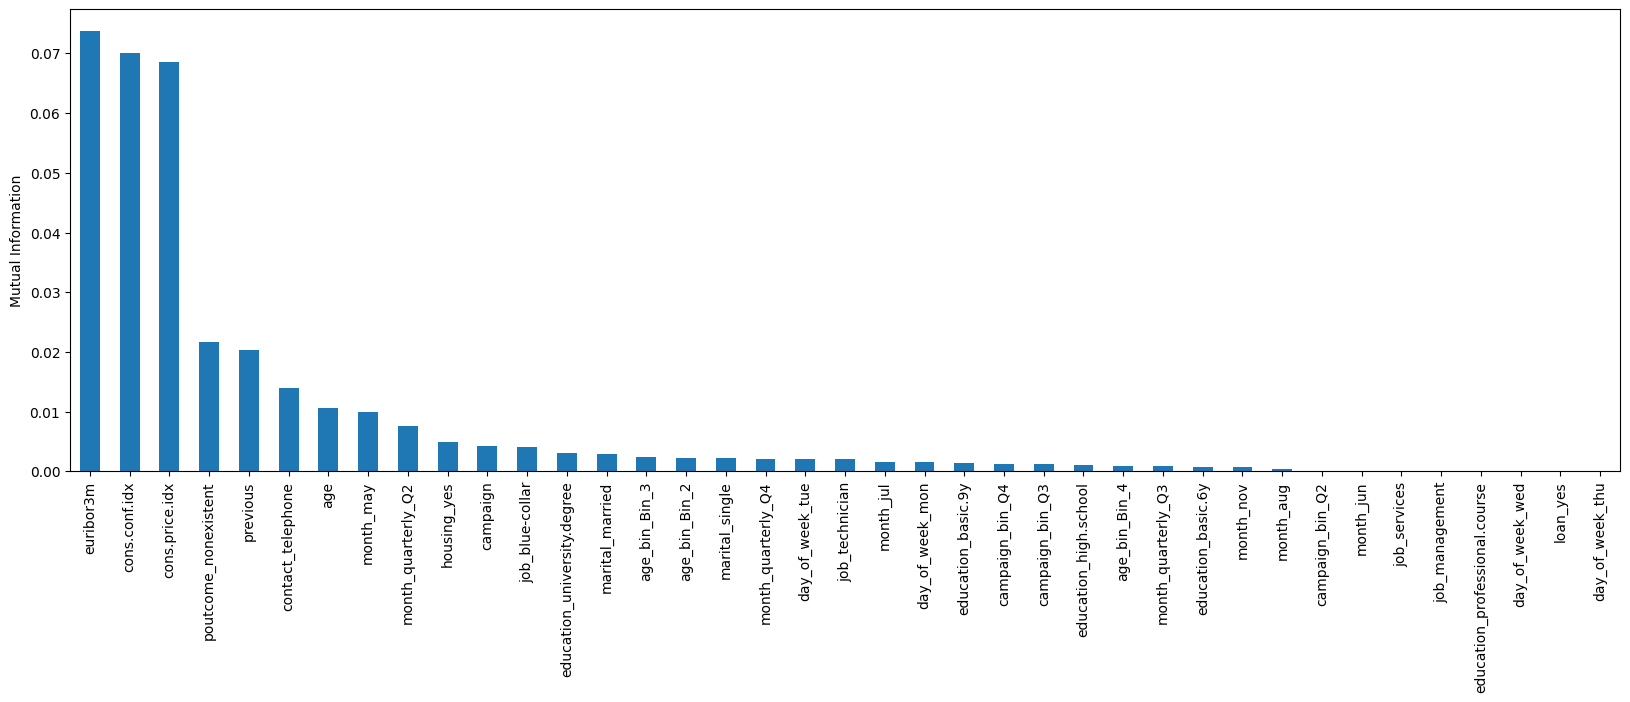

In [126]:
score_mi_ohe = mutual_info(X_train_OHE, new_cols_ohe, y_train)

In [127]:
score_mi_ohe = score_mi_ohe.sort_values(ascending=False)[:10].index

**Calculamos los features con mayor mutual information score** para las variables codificadas con **Target Mean Encoding.**

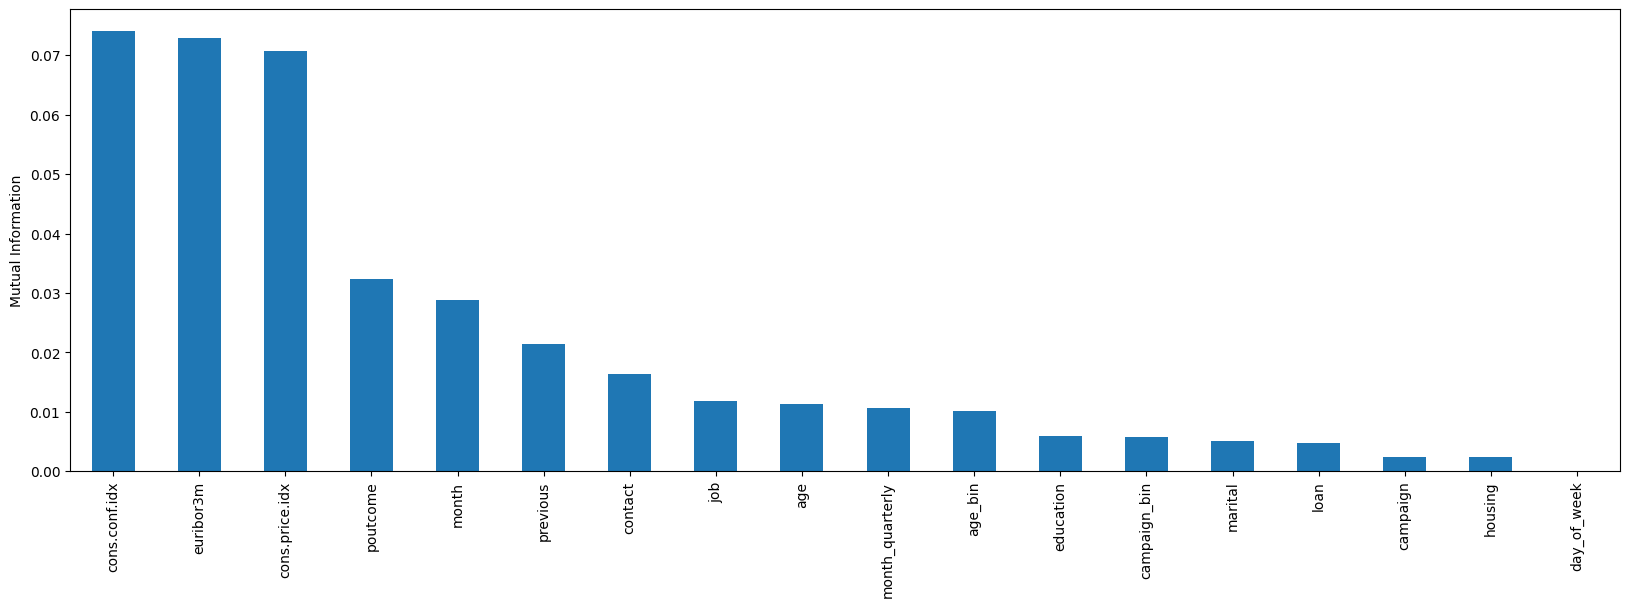

In [128]:
score_mi_tme = mutual_info(X_train_TME, new_cols_tme, y_train)

In [129]:
score_mi_tme = score_mi_tme.sort_values(ascending=False)[:11].index

# ENTRENAMIENTO Y EVALUACION DE MODELOS.

## Model performance functions.

In [147]:
def model_performance(classifier, X_train, X_test, y_train, y_test, threshold):
  
  # entreno el modelo
  classifier.fit(X_train, y_train)

  # obtengo la prediccion del conjunto train
  pred = classifier.predict_proba(X_train)

  print("Train set")
  print(f"{classifier} roc-auc: {roc_auc_score(y_train, pred[:,1])}")

  # obtengo la prediccion del conjunto de test
  pred = classifier.predict_proba(X_test)

  # comparo la prediccion obtenida con el limite dado
  pred = (pred[:,1] >= threshold).astype(bool)

  print("Test set")
  print(f"{classifier} roc-auc: {roc_auc_score(y_test, pred)}")

  print(f"Acurracy {100*accuracy_score(y_test, pred)}")

  print("-------------------------")
  print((classification_report(y_test, pred)))

  # creo y muestro la matriz de confusion
  cm = confusion_matrix(y_test, pred)
  sns.heatmap(cm, annot=True)

<a name="model-performance"></a>
## Model performance.


Vamos a analizar por separado los distintos aprouchs de feature selection combinándolos con los distintos aprouchs de encoding.

Los modelos que iremos a utilizar y analizar son: 
* GradientBoostingClassifier.
* RandomForestClassifier.
* LogisticRegression.

---

Los grupos de features a analizar son:
* `rf_importance_x` (features seleccionados con el método random forest importance)
* `best_coeff_x` (features seleccionados con el método logistic regression coeff)
* `feats_w_high_dep_x` (features seleccionados con el método chi-cuadrado)
* `score_mi_x` (features seleccionados con el metodo mutual information)

Donde los valores que puede tomar x son:

* `tme`

* `ohe`

### One Hot Encoding.

Probemos primero **los distintos aprouchs de selección** con los features codificados con **One Hot Encoding.**

**Conclusión:**

Podemos ver que son bastante similares todos los resultados obtenidos.

Sin embargo la mejor performance se da combinando el modelo de **GradientBoostingClassifier** con el conjunto de features seleccionados por el método **Logistic Regression Coeff**

Train set
GradientBoostingClassifier(random_state=0) roc-auc: 0.8027167973016764
Test set
GradientBoostingClassifier(random_state=0) roc-auc: 0.6084920221856566
Acurracy 89.70623937848993
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10969
           1       0.61      0.24      0.34      1388

    accuracy                           0.90     12357
   macro avg       0.76      0.61      0.64     12357
weighted avg       0.88      0.90      0.88     12357



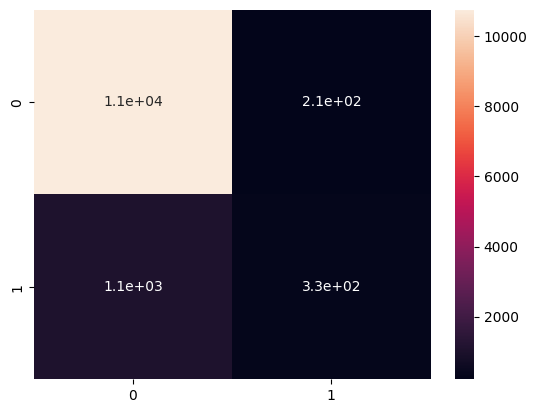

In [137]:
gbc = GradientBoostingClassifier(random_state=0)
model_performance(gbc, X_train_OHE[best_coeff_ohe], X_test_OHE[best_coeff_ohe], y_train, y_test, threshold=0.5)

Train set
LogisticRegression(random_state=0) roc-auc: 0.776456108026423
Test set
LogisticRegression(random_state=0) roc-auc: 0.5873884694172179
Acurracy 89.4229991098163
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10969
           1       0.59      0.19      0.29      1388

    accuracy                           0.89     12357
   macro avg       0.75      0.59      0.62     12357
weighted avg       0.87      0.89      0.87     12357



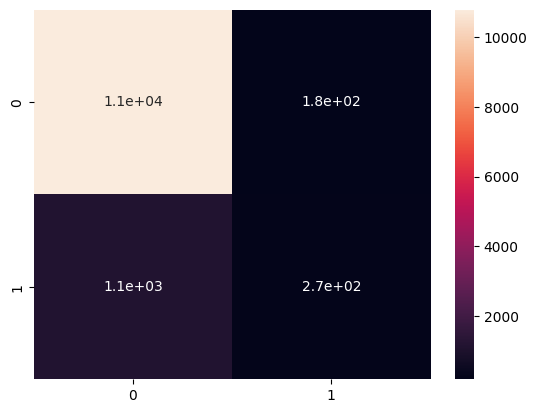

In [138]:
# para lr escalo los datos primero
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_OHE[score_mi_ohe])
X_test_scaled = scaler.transform(X_test_OHE[score_mi_ohe])

lr = LogisticRegression(random_state=0)
model_performance(lr, X_train_scaled, X_test_scaled, y_train, y_test, threshold=0.5)

Train set
RandomForestClassifier(max_depth=4, random_state=0) roc-auc: 0.7916152799082234
Test set
RandomForestClassifier(max_depth=4, random_state=0) roc-auc: 0.5675067908170867
Acurracy 89.24496236950716
-------------------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10969
           1       0.58      0.15      0.24      1388

    accuracy                           0.89     12357
   macro avg       0.74      0.57      0.59     12357
weighted avg       0.87      0.89      0.86     12357



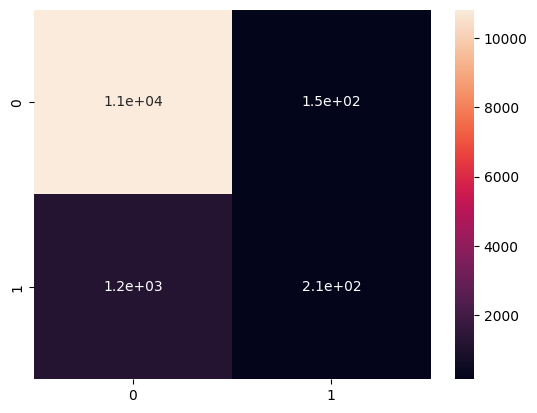

In [139]:
rfc = RandomForestClassifier(random_state=0, max_depth=4)
model_performance(rfc, X_train_OHE[best_coeff_ohe], X_test_OHE[best_coeff_ohe], y_train, y_test, threshold=0.5)

### Target Mean encoding.

Probaremos **los distintos aprouchs de selección** con los features codificados con **Target Mean Encoding.**

**Conclusión:**

Nuevamente, podemos ver que son bastante similares todos los resultados obtenidos. Salvo por rfc que obtiene un recall demasiado bajo.

Sin embargo la mejor performance se da combinando el modelo de **GradientBoostingClassifier** con el conjunto de features seleccionados por el método **Chi-cuadrado**

Train set
GradientBoostingClassifier(random_state=0) roc-auc: 0.7743076318033988
Test set
GradientBoostingClassifier(random_state=0) roc-auc: 0.5955547570136747
Acurracy 89.81144290685441
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.99      0.94     10969
           1       0.65      0.21      0.31      1388

    accuracy                           0.90     12357
   macro avg       0.78      0.60      0.63     12357
weighted avg       0.88      0.90      0.87     12357



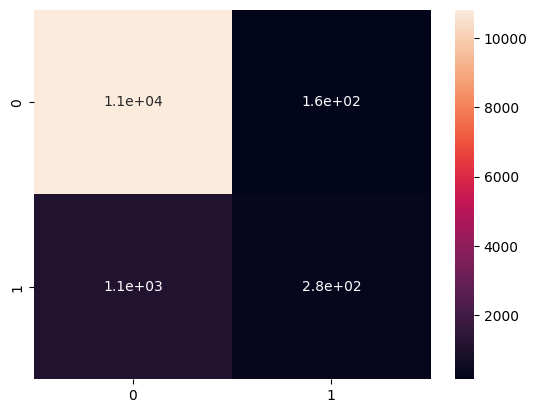

In [140]:
gbc = GradientBoostingClassifier(random_state=0)
model_performance(gbc, X_train_TME[feats_w_high_dep_tme], X_test_TME[feats_w_high_dep_tme], y_train, y_test, threshold=0.5)

Train set
LogisticRegression(random_state=0) roc-auc: 0.7676777421630896
Test set
LogisticRegression(random_state=0) roc-auc: 0.5838216319872378
Acurracy 89.7952577486445
-------------------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     10969
           1       0.67      0.18      0.28      1388

    accuracy                           0.90     12357
   macro avg       0.79      0.58      0.61     12357
weighted avg       0.88      0.90      0.87     12357



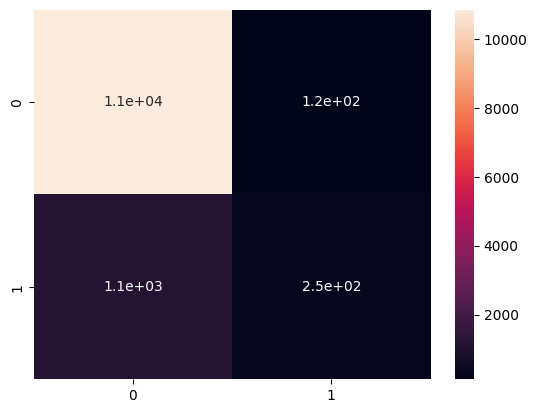

In [141]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_TME[best_coeff_tme])
X_test_scaled = scaler.transform(X_test_TME[best_coeff_tme])

lr = LogisticRegression(random_state=0)
model_performance(lr, X_train_scaled, X_test_scaled, y_train, y_test, threshold=0.5)

Train set
RandomForestClassifier(max_depth=4, random_state=0) roc-auc: 0.7743894995832558
Test set
RandomForestClassifier(max_depth=4, random_state=0) roc-auc: 0.5079206385404189
Acurracy 88.88888888888889
-------------------------
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10969
           1       0.74      0.02      0.03      1388

    accuracy                           0.89     12357
   macro avg       0.82      0.51      0.49     12357
weighted avg       0.87      0.89      0.84     12357



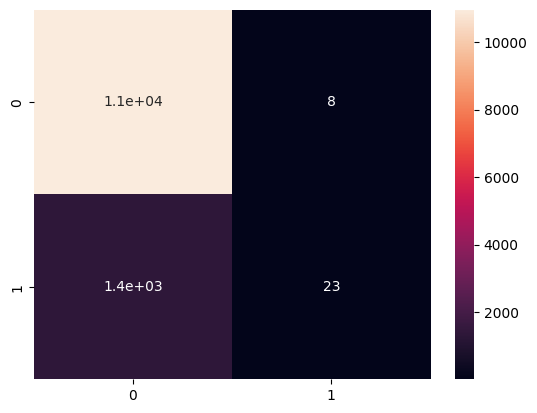

In [143]:
rfc = RandomForestClassifier(random_state=0, max_depth=4)
model_performance(rfc, X_train_TME[rf_importance_tme], X_test_TME[rf_importance_tme], y_train, y_test, threshold=0.5)

### Interpretación de resultados.

A partir de los resultados obtenidos, vemos que la **precisión** que estamos obteniendo es **bastante alta sobre todo para predecir los clientes que NO se suscriben** al depósito, PERO **si tomamos en cuenta la métrica recall** podemos observar que **estamos pudiendo capturar SOLO entre el 15-25% de los clientes que SI se suscriben** ie que hay 75-80% de clientes que se suscriben que **NO estamos pudiendo capturar con ningún modelo.**

<br/>

Esto es debido a que **tenemos MUY pocos datos de clientes que se suscribieron** al depósito comparado a los que NO se suscriben, ie **nuestra data está desbalanceada** y el modelo NO esta pudiendo encontrar patrones en los clientes que se suscriben al depósito.

<br/>

Ahora esto NO quiere decir que el modelo sea malo, ya que **dependerá de la preferencia de lo que desee predecir la empresa** ie **si la empresa quiere predecir los clientes que NO se suscriben** (ya sea para elaborar una campaña de marketing para ese sector o por otro motivo) **entonces el modelo podrá predecir con un 90% de precisión** y además **capturara el 99% de este tipo de clientes.**

<br/>

Ahora si el objetivo es predecir los empleados que SI se suscriben (ya sea para elaborar una campana para retenerlos) entonces habrá que ver que **riesgo es capaz de tomar la empresa** para poder llegar a más clientes que se suscriben (analizaremos esto ahora).

### Aumentar recall.

Podremos aumentar el recall **bajando el límite** para el cual **predecimos los clientes suscriptos**, esto **dependerá del riesgo que decida correr la empresa**, ya que **si decrementamos dicho límite entonces la precisión (al predecir los suscriptos) bajara**, **por lo que tendremos más falsos positivos a costa de capturar más clientes suscriptos.** Veamos esto.

Por ejemplo, si establecemos el límite en un 15% ie que **cdo nuestro modelo prediga que un cliente se va a suscribir, con una probabilidad del 15% o mas** entonces **seremos capaces de capturar un 60% de los suscriptos** a costa de **bajar la precisión a un 42%** ie que estaremos prediciendo mal un 60% a costa de capturar un 60% de clientes suscriptos. 


**Dependerá del trade-off que la empresa decida tener.**


Train set
GradientBoostingClassifier(random_state=0) roc-auc: 0.8034387064227184
Test set
GradientBoostingClassifier(random_state=0) roc-auc: 0.7444772640632771
Acurracy 86.42065226187586
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     10969
           1       0.42      0.59      0.49      1388

    accuracy                           0.86     12357
   macro avg       0.69      0.74      0.71     12357
weighted avg       0.89      0.86      0.87     12357



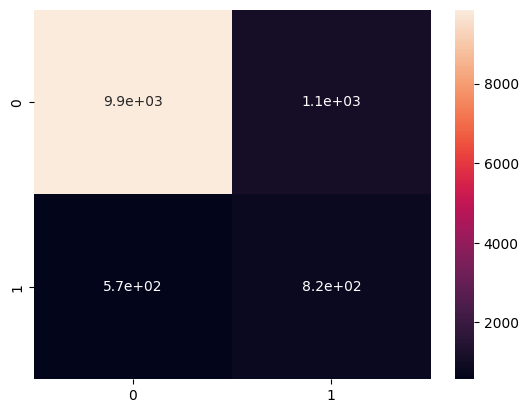

In [144]:
gbc = GradientBoostingClassifier(random_state=0)

model_performance(gbc, X_train_TME[score_mi_tme], X_test_TME[score_mi_tme], y_train, y_test, threshold=0.15)

Train set
RandomForestClassifier(max_depth=4, random_state=0) roc-auc: 0.7743894995832558
Test set
RandomForestClassifier(max_depth=4, random_state=0) roc-auc: 0.7245617922975491
Acurracy 78.91883143157725
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.81      0.87     10969
           1       0.30      0.64      0.41      1388

    accuracy                           0.79     12357
   macro avg       0.62      0.72      0.64     12357
weighted avg       0.87      0.79      0.82     12357



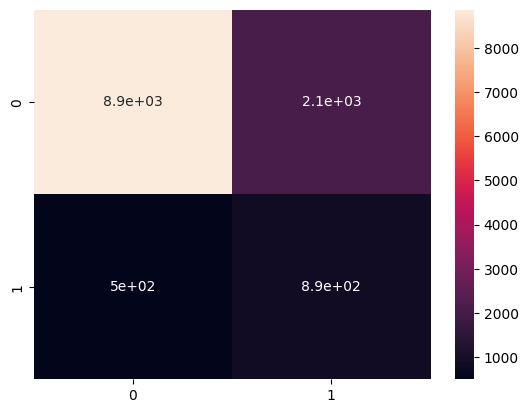

In [145]:
rfc = RandomForestClassifier(random_state=0, max_depth=4)

model_performance(rfc, X_train_TME[rf_importance_tme], X_test_TME[rf_importance_tme], y_train, y_test, threshold=0.1)